# Prerequisites

In [23]:
%matplotlib inline
%run fcast.py

# customize matplotlib plots
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH Sarabun New')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(6.5,4), dpi=300)

# Workflow

1. **Prepare data**
    1. **Transform** data i.e. taking log, scaling, and differencing.
> If data is transformed, prediction must be converted by **inversing transformation** operations.
    2. **Split** data into three sets e.g. train, validation and test set. For example, 60:20:20 proportion.
    3. For deep learning, we need to reshape data **to [Keras](https://keras.io)** format.
        1. Number of periods to used as model's input.
        2. Number of periods to forecast as model's output.


2. **Grid search** for the best hyper-parameters (configs).
    1. For each hyper-parameter, **fit the model** using **train set**.  
    2. **Walk forward validation** over the **validation set**.  
    3. **Measure** the model's performance via some metrics. In this case, we use RMSE.  
    4. For deep learning techniques, **repeat** step A-C n times because deep learning is stochastic.
    5. **Select** the best config based on RMSE.
    
    
3. **Forecast**.
    1. **Combine** train and validation set called it **train2 set**.
    2. **Refit model** using **train2 set** and the config from step 1.
    3. **Walk forward validation** over the **test set**.
    4. **Measure** the model's performance using RMSE.
    5. For deep learning techniques, **repeat** step B-D.
    6. **Return** model's performance, predicted.
    
    
4. **Evaluate** models including
    - Naive or Persistent model (NAIVE) 
    - Exponential Smoothing (ES) 
    - Seasonal Autoregressive Integrated Moving Average (SARIMA)
    - Multilayer Perceptron (MLP) 
    - Long Short-Term Memory (LSTM)

# Structure of defined functions
1. `data_` means data preparation steps
    1. `data_split`
    2. `data_transform`
    3. `data_reshape`
    
    
2. `model_` means model steps
    1. `model_config`
    2. `model_fit`
    3. `model_predict`


3. `eval_`


4. `plot_`

# Prepare data

## Import price data

โหลดข้อมูลราคาข้าวเปลือกที่เกษตรกรขายได้ 3 ชนิดข้าว ได้แก่ ข้าวหอมมะลิ (`hml`) ข้าวเจ้าขาว (`wht`) และข้าวเหนียว (`glu`)  
นอกจากนี้ ยังเพิ่มข้อมูล metadata ประกอบด้วยตัวย่อ(abb) ชื่อย่อ (shortname) และ ชื่อเต็ม(fullname)

In [2]:
hml = read_price('hml')
hml.meta = SimpleNamespace()
hml.meta.abb = 'hml'
hml.meta.shortname = 'ข้าวหอมมะลิ'
hml.meta.fullname = 'ราคาข้าวเปลือกหอมมะลิ ที่เกษตรกรขายได้ ณ ไร่นา'

wht = read_price('wht')
wht.meta = SimpleNamespace()
wht.meta.abb = 'wht'
wht.meta.shortname = 'ข้าวเจ้าขาว'
wht.meta.fullname = 'ราคาข้าวเปลือกเจ้าขาว ที่เกษตรกรขายได้ ณ ไร่นา'

glu = read_price('glu')
glu.meta = SimpleNamespace()
glu.meta.abb = 'glu'
glu.meta.shortname = 'ข้าวเหนียว'
glu.meta.fullname = 'ราคาข้าวเปลือกเหนียวเมล็ดยาว ที่เกษตรกรขายได้ ณ ไร่นา'

prices = [hml, wht, glu]

## Policy data
เพิ่มข้อมูล dummy ปีที่มีนโยบายจำนำข้าวทุกเมล็ดของรัฐบาลยิ่งลักษณ์ ระหว่าง Oct 2010 - Feb 2014

In [3]:
exo = pd.DataFrame(index = wht.index)
exo['pledge_scheme'] = 0
exo.loc['2011-10':'2014-2'] = 1

## Visualization

AttributeError: 'DataFrame' object has no attribute 'actual'

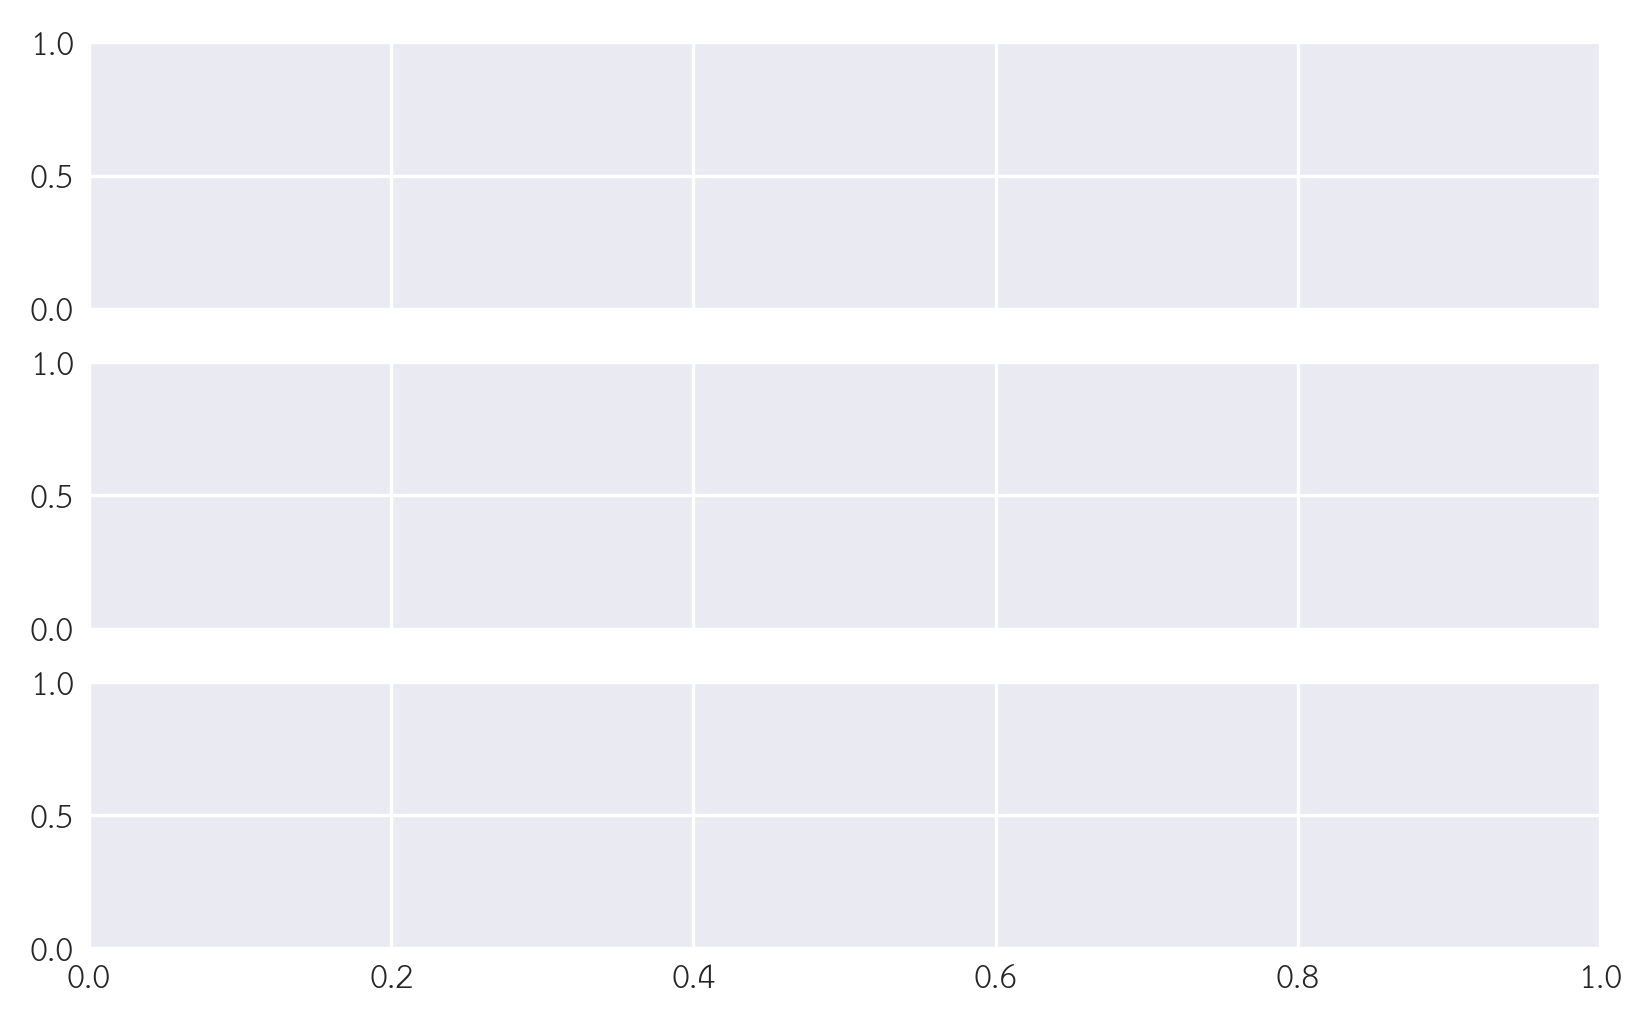

In [4]:
# fig, ax = plt.subplots(1, 1, figsize=(6.5, 3))
# # fig.subplots_adjust(hspace=1)
# for i, price in enumerate(prices):
#     ax.plot(price.index, price.actual)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# plt.tight_layout()
# # fig.savefig('../figures/01_price plot.png', dpi=300)

fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6.5, 4))
for i, price in enumerate(prices):
    ax[i].plot(price.index, price.y)
    ax[i].set_title(price.meta.fullname, loc='left')
ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
# fig.savefig('../figures/01_prices_plot.png', dpi=300)

In [ ]:
for price in prices:
    decom_mul = seasonal_decompose(price.y,
                                   model='mul',
                                   extrapolate_trend='freq',
                                  )
    decom_add = seasonal_decompose(price.y,
                                   model='add',
                                   extrapolate_trend='freq',
                                  )
    
    fig, axs = plt.subplots(4, 2, sharex=True, figsize=(6.5, 5))
    
    axs[0,0].plot(decom_mul.observed.index, decom_mul.observed)
    axs[1,0].plot(decom_mul.trend)
    axs[2,0].plot(decom_mul.seasonal)
    axs[3,0].plot(decom_mul.resid)
    
    axs[0,1].plot(decom_add.observed.index, decom_add.observed)
    axs[1,1].plot(decom_add.trend)
    axs[2,1].plot(decom_add.seasonal)
    axs[3,1].plot(decom_add.resid)
    for ix, i in enumerate(['Observed', 'Level', 'Seasonal', 'Residuals']):
        axs[ix, 0].set(ylabel=i)

    axs[3,0].set_xlabel('Multiplicative')
    axs[3,1].set_xlabel('Additive')
    plt.tight_layout()
#     fig.savefig(f'../figures/02_{price.meta.abb}_decomp.png', dpi=300)

## Stationary Test
ทดสอบคุณสมบัติ stataionry ด้วย 2 วิธี ได้แก่ Augmented Dickey–Fuller test และ KPSS test


In [5]:
res_stationary = pd.DataFrame()
for price in prices:
    res_stationary = res_stationary.append(test_stationary(price))
res_stationary

adf_stat  adf_pval  kpss_stat  kpss_pval
price       level                                          
ข้าวหอมมะลิ level   -0.9293    0.7782     2.0721     0.0100
            diff1  -13.8108    0.0000     0.0558     0.1000
ข้าวเจ้าขาว level   -1.5430    0.5121     1.9118     0.0100
            diff1   -6.0760    0.0000     0.0467     0.1000
ข้าวเหนียว  level   -0.8153    0.8146     2.0079     0.0100
            diff1   -5.7040    0.0000     0.0433     0.1000

**ผลทดสอบ**  
ผลการทดสอบ Stationary ด้วยวิธี ADF และ KPSS ระบุว่าข้อมูลราคาทั้งสามชนิดเป็นข้อมูล I(1)

## Data Transformation

In [6]:
for price in prices:
    price.scaled, price.scaler = data_transform(price, method=None)
    price.train, price.validate, price.train2, price.test = data_split(price.scaled)

# Forecast

- `<MODE_ALIAS>_fit`
- `<MODE_ALIAS>_fcast`
- `<MODE_ALIAS>_walk_forwad`

## Exponential Smoothing

In [8]:
def ets_fit(data, config, n_periods=12):
    trend, damped, seasonal = config
    return ets(data, trend=trend, damped=damped,
               seasonal=seasonal,seasonal_periods=n_periods
              ).fit(use_boxcox=True)


def ets_forecast(model_fitted, data, n_forecast=6):
    scaler = getattr(data, "scaler")
    df = pd.DataFrame(model_fitted.forecast(n_forecast),
                      columns=["yhat_scaled"])
    df['yhat'] = scaler.inverse_transform(df)
    return df['yhat']


def ets_walk_forward(data, config, search_mode=False, n_forecast=6):
    train, test = select_traintest(data, search_mode)
    n_test = test.shape[0]
    n_yhat = n_test-n_forecast
    yhat = np.empty((n_yhat, n_forecast))
    history = train
    for i in range(n_yhat):
        model_fitted = ets_fit(history, config)
        yhat[i] = ets_forecast(model_fitted, data, n_forecast)
        history = history.append(test.iloc[i])

    yhat = pd.DataFrame(yhat,
                        columns=[f'yhat{h}' for h in range(1, n_forecast+1)],
                        index=test.iloc[:n_yhat,].index)
    
    return yhat

In [30]:
trend = ['add']
damped = [True]
seasonal = ['add', 'mul']
conf1 = model_configs(trend, damped, seasonal)

trend = ['add', 'mul']
damped = [False]
seasonal = ['add', 'mul']
conf2 = model_configs(trend, damped, seasonal)
ets_configs = [*conf1, *conf2]
ets_model = [ets_fit, ets_forecast, ets_walk_forward, ets_configs]
ets_configs

[('add', True, 'add'),
 ('add', True, 'mul'),
 ('add', False, 'add'),
 ('add', False, 'mul'),
 ('mul', False, 'add'),
 ('mul', False, 'mul')]

In [32]:
%%time
for price in prices:
    price.ets_grid_result, price.ets_config = grid_search(price, ets_model)
    price.ets_yhat = forecast(price, ets_model, price.ets_config)

                   rmse      mae   mape
add-True-add 1,671.3587 980.1818 0.0764
                   rmse        mae   mape
add-True-mul 1,666.4299 1,002.3524 0.0791
                    rmse        mae   mape
add-False-add 1,979.1384 1,198.3347 0.0930
                    rmse        mae   mape
add-False-mul 1,930.3264 1,115.0183 0.0870
                    rmse        mae   mape
mul-False-add 1,995.4637 1,217.5173 0.0942
                    rmse        mae   mape
mul-False-mul 1,863.0601 1,109.6488 0.0843
                   rmse      mae   mape
add-True-add 1,574.8294 975.1950 0.1037
                   rmse      mae   mape
add-True-mul 1,579.0170 959.1516 0.1021
                    rmse        mae   mape
add-False-add 2,222.5599 1,198.6923 0.1265
                    rmse        mae   mape
add-False-mul 2,248.2813 1,118.8716 0.1204
                    rmse        mae   mape
mul-False-add 2,395.2942 1,162.4700 0.1219
                    rmse        mae   mape
mul-False-mul 2,460.1050 1,181.

In [33]:
# plot_fcast(hml, method='hws')

## ARIMA

In [133]:
p_params = list(range(6))
q_params = [0, 1, 2]
P_params = [0, 1, 2]
Q_params = [0, 1, 2]
# t_params = ['n','c','t','ct']
m_params = 12
order = model_configs(p_params, [1], q_params)
sorder = model_configs(P_params, [1], Q_params, [12])
# model_configs(order, sorder)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(history,
                order=order, seasonal_order=sorder, trend=trend,
                enforce_stationarity=False, enforce_invertibility=False)
# fit model
model_fit = model.fit(disp=False)

In [ ]:
def arima_fit(data, config, n_periods=12):
    return pm.auto_arima(train,
                         start_p=0, start_q=0, # starting p, q
                         max_p=6, max_q=6, # maximum p, q
                         start_P=0, start_Q=0, # starting P, Q
                         m=12, seasonal=True, # monthly data
                         d=1, D=0, # first difference is sufficient suggested by test
                         information_criterion='aic',
                        )

def arima_fcast(model, n_fcast, data):
    scaler = getattr(data, "scaler")
    df = pd.DataFrame(model.forecast(n_fcast), columns=["fcast_scaled"])
    df['fcast'] = scaler.inverse_transform(df)
    return df['fcast']

In [371]:
def fit_arima(df, end_train='2012-12', use_exo=False):
    """
    Create an auto ARIMA model
    """
    train = df.loc[:end_train]
    return pm.auto_arima(train,
                         exogenous=exo.loc[:end_train] if use_exo==True else None,
                         start_p=0, start_q=0, # starting p, q
                         max_p=6, max_q=6, # maximum p, q
                         start_P=0, start_Q=0, # starting P, Q
                         m=12, seasonal=True, # monthly data
                         d=1, D=0, # first difference is sufficient suggested by test
                         information_criterion='aic',
                        )

def rolling_arima(df, start_test='2012-12', n_fcast=6, use_exo=False, learning_rate=None):
    """
    Input: a dictionary containing the dataframe
    Ouput: a rolling multi-period forecast
    learning rate: int indicating how many periods required for reselect pqPQ
    """
    
    # parameterize
    n_train = df.loc[:start_test].shape[0]
    n_test = df.loc[start_test:].shape[0]
    learning_rate = n_test if learning_rate is None else learning_rate
    
    # create an empty container for forecast and selected orders
    fcast = np.empty((n_test, n_fcast))
    orders = []
    
    # fit or update model, then forecast and store results 
    for i in range(n_test):
        end_train = df.iloc[n_train+i-1].name
        x = np.repeat(exo.iloc[n_train+i-1].values, n_fcast).reshape(-1, 1) if use_exo==True else None
        if i % learning_rate== 0:
            model = fit_arima(df, end_train, use_exo=use_exo)
        else:
            model = model.update(df.loc[end_train], exogenous=exo.loc[end_train].values.reshape(-1,1))
        fcast[i] = model.predict(n_fcast, exogenous=x)
        orders.append(str(model.order + model.seasonal_order))
        
    res = pd.DataFrame(fcast,
                       columns=[f'fcast{i}' for i in range(1, n_fcast+1)],
                       index=df.index[n_train-1:])
    res['orders'] = orders

    return res

In [359]:
path = 'fcast_arima.pkl'

if(os.path.isfile(path)):
    fcast_ = joblib.load(path)
else:
    fcast_ = dict()
    for price in prices:
        fcast_[price.meta.abb] = rolling_arima(price, use_exo=False, learning_rate=None)
    joblib.dump(fcast_, path)
    
for price in prices:
    price.fcast_arima = fcast_[price.meta.abb]

In [372]:
path = 'fcast_arimax.pkl'

if(os.path.isfile(path)):
    fcast_ = joblib.load(path)
else:
    fcast_ = dict()
    for price in prices:
        fcast_[price.meta.abb] = rolling_arima(price, use_exo=True, learning_rate=None)
    joblib.dump(fcast_, path)
    
for price in prices:
    price.fcast_arimax = fcast_[price.meta.abb]

In [400]:
path = 'fcast_arima1.pkl'

if(os.path.isfile(path)):
    fcast_ = joblib.load(path)
else:
    fcast_ = dict()
    for price in prices:
        fcast_[price.meta.abb] = rolling_arima(price, use_exo=False, learning_rate=12)
    joblib.dump(fcast_, path)
    
for price in prices:
    price.fcast_arima1 = fcast_[price.meta.abb]

In [402]:
path = 'fcast_arimax1.pkl'

if(os.path.isfile(path)):
    fcast_ = joblib.load(path)
else:
    fcast_ = dict()
    for price in prices:
        fcast_[price.meta.abb] = rolling_arima(price, use_exo=True, learning_rate=12)
    joblib.dump(fcast_, path)
    
for price in prices:
    price.fcast_arimax1 = fcast_[price.meta.abb]

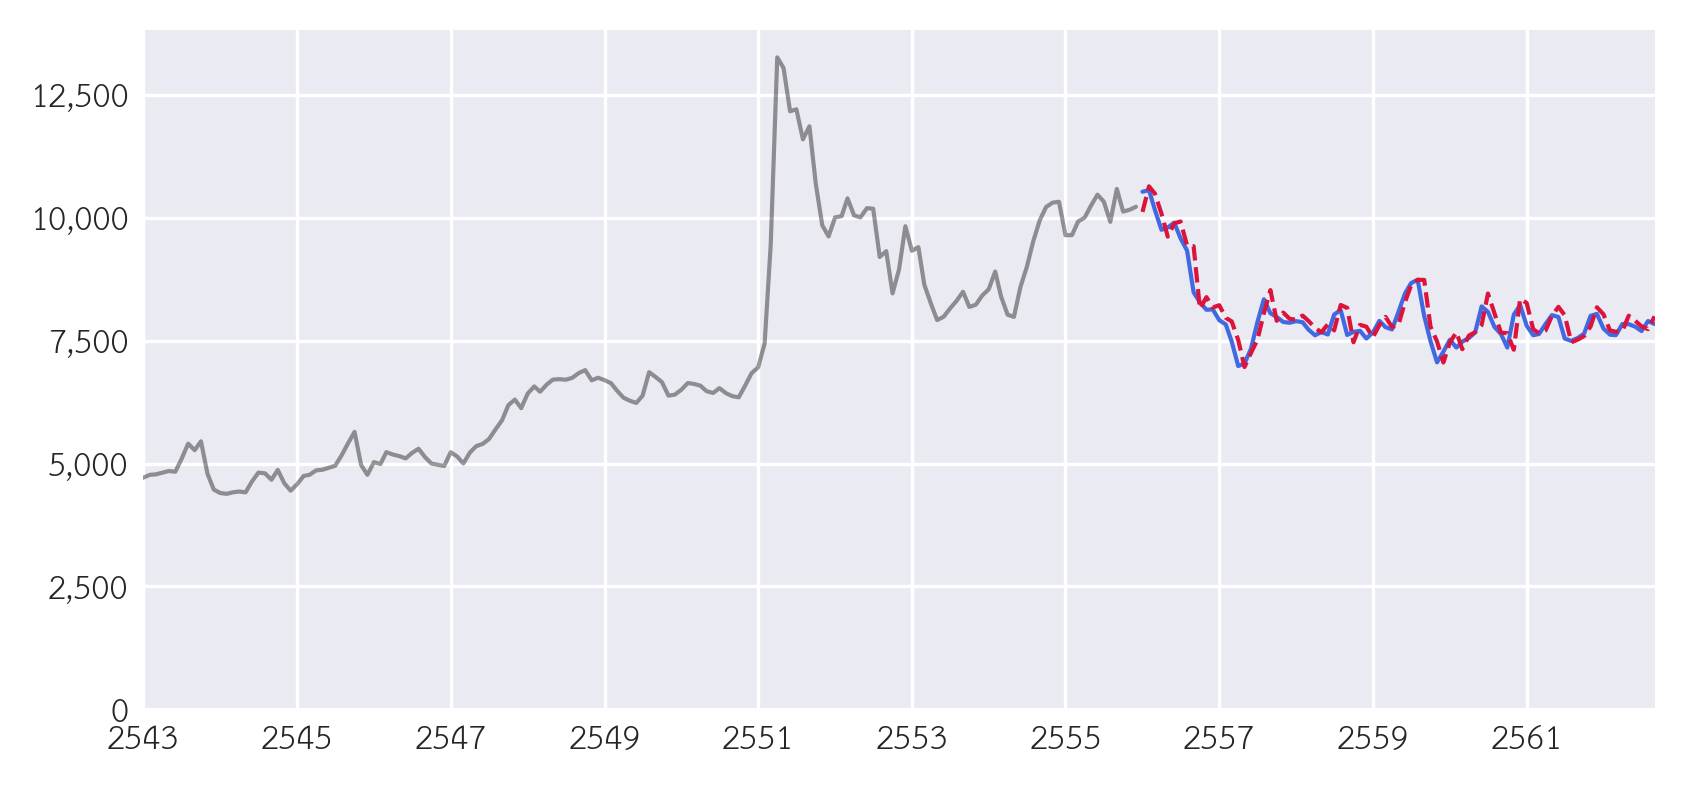

In [375]:
plot_fcast(wht, method='arima')

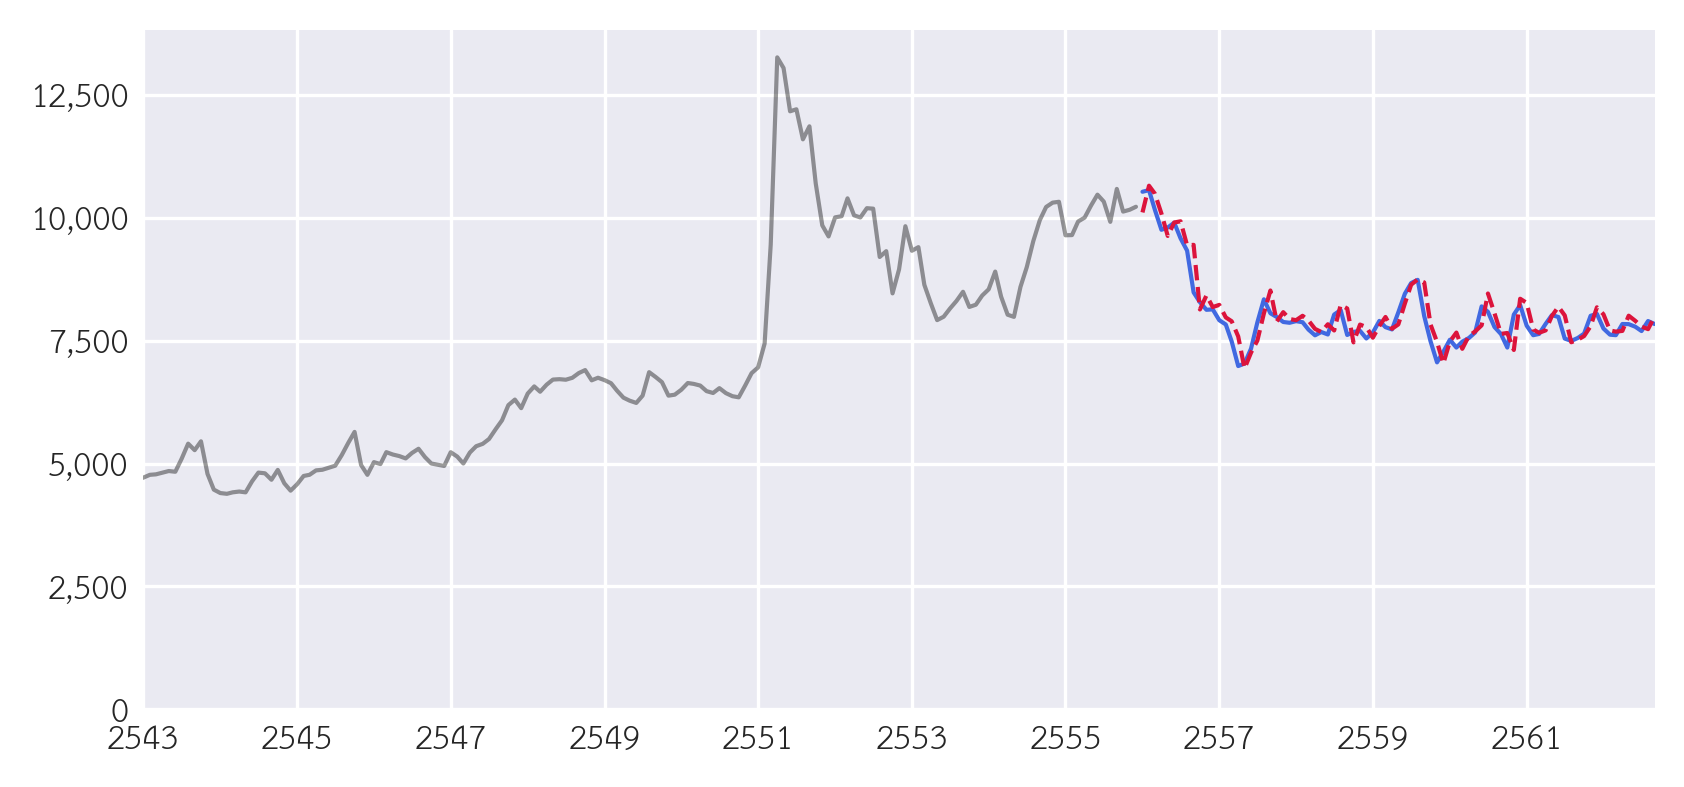

In [376]:
plot_fcast(wht, method='arimax')

## MLP

## LSTM

In [531]:
def fit_lstm(df, end_train='2012-12', n_lag=12, n_fcast=6, n_batch=1, n_epoch=500, n_neurons=1):
    # reshape training into [samples, timesteps, features]
    train, test = split_train_test(df, end_train=end_train)
    X, y = train.to_numpy()[:, :n_lag], train.to_numpy()[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1]) #samples, #time step = 1, #features = number of lags 
    
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # fit network
    for i in range(n_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

def rolling_lstm(df, start_test='2012-12', n_lag=12, n_fcast=6, n_batch=1, n_epoch=500, n_neurons=1):
    """
    Input: a dictionary containing the dataframe
    Ouput: a rolling multi-period forecast
    learning rate: int indicating how many periods required for reselect pqPQ
    """
    
    # parameterize
    n_train = df.loc[:start_test].shape[0]
    n_test = df.loc[start_test:].shape[0]
    
    # create an empty container for forecast and selected orders
    fcast = np.empty((n_test, n_fcast))
    
    for i in range(n_test):
        X = price.test.iloc[0, :n_lag].to_numpy().reshape(1,1,-1)
        fcast[i] = model.predict(X, batch_size=1)
    
    return pd.DataFrame(fcast,
                        columns=[f'fcast{i}' for i in range(1, n_fcast+1)],
                        index=df.index[n_train-1:])

In [532]:
model = fit_lstm(hml)

In [533]:
X = hml.test.iloc[0, :12].to_numpy().reshape(1,1,-1)
fcast = model.predict(X, batch_size=1)
fcast

array([[ 0.38518608,  0.13034333, -0.4535573 , -0.5097825 , -0.01228837,
         0.19826972]], dtype=float32)

In [544]:
hml.train

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,y1,y2,y3,y4,y5,y6
date,,,,,,,,,,,,,,,,,,
1985-01-01,0.1481,-1.0552,-1.0359,-0.9593,-0.9463,-0.8798,2.8694,0.0386,0.0494,0.5723,-0.2288,-0.1971,-0.3367,0.5990,-0.3271,-0.1996,0.5258,-0.7171
1985-02-01,-0.3367,0.1481,-1.0552,-1.0359,-0.9593,-0.9463,-0.8798,2.8694,0.0386,0.0494,0.5723,-0.2288,0.5990,-0.3271,-0.1996,0.5258,-0.7171,0.0974
1985-03-01,0.5990,-0.3367,0.1481,-1.0552,-1.0359,-0.9593,-0.9463,-0.8798,2.8694,0.0386,0.0494,0.5723,-0.3271,-0.1996,0.5258,-0.7171,0.0974,0.0521
1985-04-01,-0.3271,0.5990,-0.3367,0.1481,-1.0552,-1.0359,-0.9593,-0.9463,-0.8798,2.8694,0.0386,0.0494,-0.1996,0.5258,-0.7171,0.0974,0.0521,-0.2809
1985-05-01,-0.1996,-0.3271,0.5990,-0.3367,0.1481,-1.0552,-1.0359,-0.9593,-0.9463,-0.8798,2.8694,0.0386,0.5258,-0.7171,0.0974,0.0521,-0.2809,-0.2902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-01,0.5830,0.1973,-0.0886,-0.2292,-0.0959,-0.3881,-0.2896,0.1673,-0.3360,1.1214,1.2541,0.3955,0.1284,0.2504,-0.6797,0.0276,0.3018,0.3541
2012-09-01,0.1284,0.5830,0.1973,-0.0886,-0.2292,-0.0959,-0.3881,-0.2896,0.1673,-0.3360,1.1214,1.2541,0.2504,-0.6797,0.0276,0.3018,0.3541,-0.3139
2012-10-01,0.2504,0.1284,0.5830,0.1973,-0.0886,-0.2292,-0.0959,-0.3881,-0.2896,0.1673,-0.3360,1.1214,-0.6797,0.0276,0.3018,0.3541,-0.3139,-0.3300


In [550]:
hml.iloc[347]

value   15,386.0000
Name: 2012-12-01 00:00:00, dtype: float64

In [534]:
hml.test.iloc[0, 12:]

y1    0.3541
y2   -0.3139
y3   -0.3300
y4    0.1214
y5   -0.0024
y6   -0.4186
Name: 2013-01-01 00:00:00, dtype: float64

In [551]:
data_inverse(fcast, hml, hml.scaler, 347)

array([15386.        , 15470.46111619, 15788.1957914 , 16158.21591949,
       15949.07410796, 15728.87191217])

In [552]:
hml.iloc[347:347+6]

,value
date,
2012-12-01,"15,386.0000"
2013-01-01,"15,702.0000"
2013-02-01,"16,070.0000"
2013-03-01,"15,862.0000"
2013-04-01,"15,643.0000"
2013-05-01,"15,809.0000"


In [ ]:
# X = X.reshape(1, 1, len(X))
# make forecast
fcast = model.predict(X, batch_size=n_batch)


In [434]:
# model.predict(hml.sup_scaled.dropna())

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

n_train = 348
train_hml = lstm_prepossesing(hml)

# # สร้าง LSTM network ด้วย library Keras โดยกำหนดขนาด hidden layer(50) และ shape ของข้อมูล input(#rows x #features)
# model = Sequential()
# model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
# # สร้าง hidden layer ตามขนาด output หรือ จำนวนวันที่ต้องการ forecast (6) 
# model.add(Dense(6))
# model.compile(loss='mae', optimizer='adam')

# design network
model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
for i in range(nb_epoch):
    model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
    model.reset_states()

# train โมเดล และเก็บ log
history = model.fit(train_X, train_y, epochs=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# # พล็อตค่า train&test loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [406]:
hml.sup_scaled

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,y1,y2,y3,y4,y5,y6
date,,,,,,,,,,,,,,,,,,
1984-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.1971,-0.2288,0.5723,0.0494,0.0386,2.8694
1984-02-01,-0.1971,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.2288,0.5723,0.0494,0.0386,2.8694,-0.8798
1984-03-01,-0.2288,-0.1971,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.5723,0.0494,0.0386,2.8694,-0.8798,-0.9463
1984-04-01,0.5723,-0.2288,-0.1971,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0494,0.0386,2.8694,-0.8798,-0.9463,-0.9593
1984-05-01,0.0494,0.5723,-0.2288,-0.1971,nan,nan,nan,nan,nan,nan,nan,nan,0.0386,2.8694,-0.8798,-0.9463,-0.9593,-1.0359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,0.0207,-0.1617,0.0810,0.4611,-0.1937,-0.1170,0.4348,-0.4093,-0.3301,-0.8285,0.0470,0.3354,-0.0207,-0.3838,0.5434,0.5702,nan,nan
2019-06-01,-0.0207,0.0207,-0.1617,0.0810,0.4611,-0.1937,-0.1170,0.4348,-0.4093,-0.3301,-0.8285,0.0470,-0.3838,0.5434,0.5702,nan,nan,nan
2019-07-01,-0.3838,-0.0207,0.0207,-0.1617,0.0810,0.4611,-0.1937,-0.1170,0.4348,-0.4093,-0.3301,-0.8285,0.5434,0.5702,nan,nan,nan,nan


# Evaluate

In [396]:
def eval_fcast(df, method='arima', metrics=rmse, n_fcast=6):
    """
    Evaluate forecast accuracy
    """
    actual = df.rename(columns={'value':'actual'})
    fcast  = getattr(df, f'fcast_{method}')
    df = actual.join(fcast).dropna()
    
    res = []
    for i in range(n_fcast):
        _ = metrics(df['actual'].iloc[i+1:],
                    df[f'fcast{i+1}'].shift(i+1).dropna()
                   )
        res.append(_)
    return np.array(res).sum()

In [403]:
methods = ['hws', 'arima', 'arimax', 'arima1', 'arimax1']
eval_df = pd.DataFrame()
for price in prices:
    for method in methods:
        eval_df.loc[price.meta.shortname, method] = eval_fcast(price, method)
eval_df

,hws,arima,arimax,arima1,arimax1
ข้าวหอมมะลิ,"6,503.7918","6,360.8259","6,368.8576","6,346.2891","6,290.1087"
ข้าวเจ้าขาว,"3,562.2058","3,484.8186","3,522.2407","3,482.6913","3,526.0097"
ข้าวเหนียว,"5,096.6697","7,003.5524","5,891.0336","6,678.8419","6,188.6085"


# Appendix

In [ ]:
plt.rcParams.update({'figure.figsize':(12,10), 'figure.dpi':300})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df.price); axes[0, 0].set_title('Original Series')
plot_acf(df.price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.price.diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.price.diff().dropna().values, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.price.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.price.diff().diff().dropna().values, ax=axes[2, 1])

plt.show()


plt.rcParams.update({'figure.figsize':(12,10), 'figure.dpi':300})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df.price); axes[0, 0].set_title('Original Series')
plot_pacf(df.price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.price.diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(df.price.diff().dropna().values, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.price.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(df.price.diff().diff().dropna().values, ax=axes[2, 1])

plt.show()

In [ ]:
for price in prices:
    supervised = series2supervised(price['data'])
    scaler, scaled = data_transform(price['data'])
    
    
    X_train, X_test, y_train, y_test, n_train, n_test, N = split_train_test(supervised)
    price['train'] = (X_train, y_train)
    price['test']  = (X_test,  y_test)
    
    
    supervised_scaled = series2supervised(scaled)
    X_train, X_test, y_train, y_test, n_train, n_test, N = split_train_test(supervised_scaled)
    rice['train_scaled'] = (X_train, y_train)
    rice['test_scaled'] = (X_test,  y_test)
    rice['scaled'] = scaled
    rice['scaler'] = scaler
    rice['n_train'] = n_train
    rice['n_test'] = n_test
    rice['N'] = N

In [ ]:
def rolling_arima(dt, n_fcast=6, scaled=False, reselect_orders=False):
    N, n_train, n_test = dt['N'], dt['n_train'], dt['n_test']
    df = dt['data'].values
    data_transform(df)
    
    fcast = np.empty((n_test, n_fcast))
    
    # กรณี p,q,P,Q sarima ถูกกำหนดโดย training data แล้ว fix
    if reselect_orders == False:
        # สร้าง empty container สำหรับ forecast value และ orders ของ arima
        fcast = np.empty((n_test, n_fcast))
        orders = []
        
        # estimate arima โดยใช้ train dataset
        model = arima(df, n_train)
        
        # forecast
        fcast[0] = model.predict(n_fcast)
        orders.append(str(model.order + model.seasonal_order))
        
        # refit arima model โดยใช้ update method กับข้อมูลใหม่
        for i in range(1, n_test):
            model = model.update(df['data'][n_train+i:n_train+i+1])
            fcast[i] = model.predict(n_fcast)
            orders.append(str(model.order + model.seasonal_order))
            
    # กรณีหา p,q,P,Q ทุกครั้ง
    else:
        # สร้าง empty container สำหรับ forecast value และ orders ของ arima
        fcast = np.empty((n_test, n_fcast))
        orders = []
        for i in range(n_test):
            # estimate arima โดยใช้ข้อมูลจากอดีตถึงปัจจุบัน
            model = arima(df, n_train+i)
            fcast[i] = model.predict(n_fcast)
            orders.append(str(model.order + model.seasonal_order))        
    
    res = pd.DataFrame(fcast,
                       columns=[f'fcast{i}' for i in range(1,n_fcast+1)],
                       index=df['data'].index[-n_test:])
    res['orders'] = orders
    return res

In [ ]:
def forecast_accuracy(forecast, actual):
    diff = forecast-actual
    mape = np.mean( np.abs(diff)/np.abs(actual) )
    rmse = np.mean( diff**2 ) **0.5
    return ({'mape': mape,
             'rmse': rmse,
            })

In [ ]:
# fcast_arima = dict()
# for price in prices:
#     fcast_arima[price['abb']] = rolling_arima(price, use_exo=False)
#     price['fcast_arima'] = fcast_arima[price['abb']]
# joblib.dump(fcast_arima, 'fcast_arima.pkl')

# fcast_arimax = dict()
# for price in prices:
#     fcast_arimax[price['abb']] = rolling_arima(price, use_exo=True)
#     price['fcast_arimax'] = fcast_arimax[price['abb']]
# joblib.dump(fcast_arimax, 'fcast_arimax.pkl')